In [1]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

import pandas as pd

import glob

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

import MagellanicStream as ms

import dlnpyutils

import warnings
warnings.filterwarnings('ignore')

##############################
### User defined functions ###
##############################

#find duplicates in data
def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

#calculate absolute mag
def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

def dist2LMCtest(ra, dec, alph0, delt0, pa, io):
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = io*np.pi/180 #np.radians(io) #inclination #25.86
    pa = pa*np.pi/180 #np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dis

def readmist(file):
    with open(file) as f:
        #lines = f.readlines()
        df = pd.read_csv(file,comment='#',names = ['EEP','log10_isochrone_age_yr','initial_mass',\
                                                   'star_mass','log_Teff','log_g','log_L','FeH_init',\
                                                   'FeH','Bessell_U','Bessell_B','Bessell_V','Bessell_R',\
                                                   'Bessell_I','2MASS_J','2MASS_H','2MASS_Ks','Kepler_Kp',\
                                                   'Kepler_D51','Hipparcos_Hp','Tycho_B','Tycho_V',\
                                                   'Gaia_G_DR2Rev','Gaia_BP_DR2Rev','Gaia_RP_DR2Rev',\
                                                   'Gaia_G_MAW','Gaia_BP_MAWb','Gaia_BP_MAWf','Gaia_RP_MAW',\
                                                   'TESS','phase'],sep='\s+')
        table_out = Table.from_pandas(df)
    return table_out

def sal(MH,aM):
    return MH + np.log(0.638*(10**(aM))+0.362)

def mad(dat): #median absolute deviation
    return np.median(np.absolute(dat - np.median(dat)))

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
#########################
### Import fits files ###
#########################

#MIST
files = glob.glob('/Users/joshpovick/desktop/research/Magellanic_Ages/MIST/*.iso.cmd')

noperiod = []
for i in range(len(files)):
    #new_files.append('/Users/joshpovick/Desktop/Research/Magellanic_Ages/BaSTI/'+files[i])
    splt = files[i].split('.')
    noperiod.append(splt[0]+splt[1]+splt[2])

for j in range(len(files)):
    tab = readmist(files[j])
    tab.write('{}.dat'.format(noperiod[j]),format='csv',overwrite=True)
    
datfiles = glob.glob('/Users/joshpovick/Desktop/Research/Magellanic_Ages/MIST/*.dat')
output_file = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/MIST_monarch.dat'
for i, fname in enumerate(datfiles):
    df = pd.read_csv(fname)
    if i==0:
        df.to_csv(output_file, index = False)
    else:
        df.to_csv(output_file, mode = 'a+', index = False, header = False)
        
mistall = pd.read_csv('/Users/joshpovick/Desktop/Research/Magellanic_Ages/MIST_monarch.dat')
tmistall = Table.from_pandas(mistall)
rgb = np.where((tmistall['EEP']>=495)&(tmistall['EEP']<=605)&(tmistall['log_Teff']<=3.75))
mist = tmistall[rgb]

#DR16
lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembers_r13-l33-58672.fits',1)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0)&(lmcdr16['LOGG']>0.0)&\
                (lmcdr16['M_H_ERR']>-90.0)&(lmcdr16['C_FE']>-9999.0)&(lmcdr16['N_FE']>-9999.0))

clndr16 = lmcdr16[clnr]

#old dr16
olddr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembersdist_dr16beta.fits',1)
clnrold = np.where((olddr16['FE_H']>-9999.0)&(olddr16['AK_TARG']>-9999.0)&(olddr16['LOGG']>0.0)&\
                (olddr16['M_H_ERR']>-90.0)&(olddr16['C_FE']>-9999.0)&(olddr16['N_FE']>-9999.0))

clnrolddr16 = olddr16[clnrold]

#Diane Feuillet
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/LMC_DR16_all_PDF.fits', 1)
clnpdfout = pdfout[ np.where((olddr16['FE_H']>-9999.0)&(olddr16['AK_TARG']>-9999.0)&(olddr16['LOGG']>0.0)&\
                (olddr16['M_H_ERR']>-90.0)&(olddr16['C_FE']>-9999.0)&(olddr16['N_FE']>-9999.0))]

#Read in Christian's Model
Chrismod = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/abparam16_delgau1.5_1525.txt')

In [3]:
############################################
### Create a list of all possible models ###
############################################

import itertools as it

y1 = mist['log_Teff']
y2 = mist['2MASS_Ks']
y3 = mist['FeH']
y4  = mist['log_g']
y12 = np.multiply(y1,y2)
y13 = np.multiply(y1,y3)
y14 = np.multiply(y1,y4)
y23 = np.multiply(y2,y3)
y24 = np.multiply(y2,y4)
y34 = np.multiply(y3,y4)
y1sq = y1**2
y2sq = y2**2
y3sq = y3**2
y4sq = y4**2

models = []
models_str = []
all_var_str = ['y1','y2','y3','y4','y12','y13','y14','y23','y24','y34','y1sq','y2sq','y3sq','y4sq']
all_var = [y1,y2,y3,y4,y12,y13,y14,y23,y24,y34,y1sq,y2sq,y3sq,y4sq]
for i in range(4, len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
    
idx = []
for j in range(len(models_str)):
    if models_str[j][0]=='y1' and models_str[j][1]=='y2' and models_str[j][2]=='y3' and models_str[j][3]=='y4':
        idx.append(j)
        
models = np.array(models)[idx]
models_str_good = np.array(models_str)[idx]

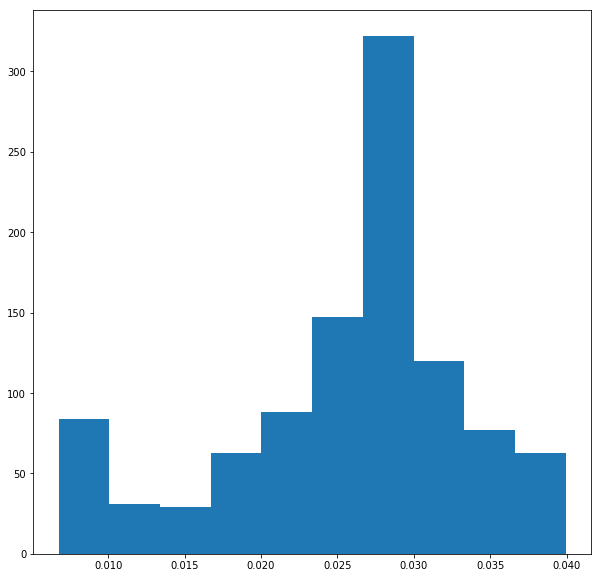

0.006752074821650744
[array(['y1', 'y2', 'y3', 'y4', 'y14', 'y24', 'y2sq', 'y3sq', 'y4sq'],
      dtype='<U4')]
[array([11.95633625,  4.29637009,  3.47288991,  0.24495181, -6.09562956,
       -0.61658645, -0.69137712,  0.14681993,  0.06654658,  0.82262236])]


In [4]:
######################
### Fit All Models ###
######################

import statsmodels.api as sm 

model_mads = []
model_params = []
model_res = []
for i in range(len(models)):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(mist['log10_isochrone_age_yr'],pmodl).fit()
    predictions = model.predict(pmodl)
    residual = predictions - mist['log10_isochrone_age_yr']
    model_res.append(max(np.absolute(residual)))
    model_mads.append(mad(residual))
    model_params.append(np.asarray(model.params))
    
plt.figure(figsize=[10,10])
plt.hist(model_mads)
plt.show()
    
best = np.where(model_mads == min(model_mads))
print(min(model_mads))
print(models_str_good[best])
print(np.asarray(model_params)[best])

In [5]:
#########################
### Find lowest order ###
#########################

small = np.where(np.asarray(model_mads)<=0.01)

terms = []
for i in range(len(models_str_good[small])):
    terms.append(len(models_str_good[small][i]))
    
print(terms)
for j in range(6):
    print(models_str_good[small][j])

[8, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14]
['y1' 'y2' 'y3' 'y4' 'y24' 'y2sq' 'y3sq' 'y4sq']
['y1' 'y2' 'y3' 'y4' 'y12' 'y24' 'y2sq' 'y3sq' 'y4sq']
['y1' 'y2' 'y3' 'y4' 'y13' 'y24' 'y34' 'y2sq' 'y4sq']
['y1' 'y2' 'y3' 'y4' 'y13' 'y24' 'y2sq' 'y3sq' 'y4sq']
['y1' 'y2' 'y3' 'y4' 'y14' 'y24' 'y2sq' 'y3sq' 'y4sq']
['y1' 'y2' 'y3' 'y4' 'y23' 'y24' 'y2sq' 'y3sq' 'y4sq']


In [7]:
parsimonious = np.array([y1,y2,y3,y4,y24,y2sq,y4sq]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(mist['log10_isochrone_age_yr'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - mist['log10_isochrone_age_yr']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.284e+06
Date:                Fri, 20 Sep 2019   Prob (F-statistic):               0.00
Time:                        09:39:37   Log-Likelihood:                 54767.
No. Observations:               26714   AIC:                        -1.095e+05
Df Residuals:                   26706   BIC:                        -1.095e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.2848      0.122    150.044      0.0

In [9]:
def mist_age(w,x,y,z):
    p=[18.28482966,  2.49907862,  3.48490805,  0.10394635, -8.1833216,  -0.69825115,\
       0.14819764,  0.78780835]
    return p[0]+p[1]*w+p[2]*x+p[3]*y+p[4]*z+p[5]*np.multiply(x,z)+p[6]*(x**2)+p[7]*(z**2)

In [10]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(clndr16)):
    x_C.append(sol_xm[0]*10**(clndr16['C_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_N.append(sol_xm[1]*10**(clndr16['N_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_O.append(sol_xm[2]*10**(clndr16['O_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Mg.append(sol_xm[3]*10**(clndr16['Mg_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Ca.append(sol_xm[4]*10**(clndr16['Ca_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_S.append(sol_xm[5]*10**(clndr16['S_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Si.append(sol_xm[6]*10**(clndr16['SI_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Fe.append(sol_xm[7]*10**(clndr16['FE_H']-clndr16['M_H']))
    
factsCN = []
for j in range(len(clndr16)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    factsCN.append(numerCN/denomCN)
factsCN = factsCN[0]

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

stardist = dist2LMCtest(clndr16['RA'],clndr16['DEC'],82.25, -69.5, 146.37, 27.81)
corabsK = absmag(clndr16['K'],stardist,False)-clndr16['AK_TARG']
misage = mist_age(np.log10(clndr16['TEFF']),corabsK,sal(clndr16['M_H'],metscorr),clndr16['LOGG'])

In [11]:
####################################
### Get Uncertainties: Add Noise ###
####################################

'''in alpha w/o C and N, out alpha w/ C and N'''

def noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR,lgg,lggERR):
    carbon = 0.28115244582676185 # derived in initial age calc
    nitrogen = 0.06901474154376043 # derived in initial age calc
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    expcarERR = 10**(cm)*np.log(10)*CMERR
    expnitERR = 10**(nm)*np.log(10)*NMERR
    
    xcarb = carbon*10**(cm)
    xnitr = nitrogen*10**(nm)
    fac = (xcarb+xnitr)/(carbon+nitrogen) #factor from Salaris correction
    facERR = np.sqrt((expcarERR)**2+(expnitERR)**2)/(carbon+nitrogen)
    
    facnoise = np.random.normal(0, np.absolute(0.434*(facERR/fac)))
    
    lggnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    facnew = fac + ((-1)**np.random.randint(2))*facnoise
    lggnew = lgg + ((-1)**np.random.randint(2))*lggnoise
    return Tnew, Knew, MHnew, facnew, lggnew

In [12]:
######################################
### Get Uncertainties: Calc Uncert ###
######################################

devs = []

for i in range(len(clndr16)):
    lgT = np.log10(clndr16['TEFF'][i])
    lgTERR = 0.434*(np.log(clndr16['TEFF_ERR'][i])/np.log10(clndr16['TEFF'][i]))
    ks = corabsK[i]
    ksERR = clndr16['K_ERR'][i]
    mh = clndr16['M_H'][i]
    mhERR = clndr16['M_H_ERR'][i]
    cfe = clndr16['C_FE'][i]
    cfeERR = clndr16['C_FE_ERR'][i]
    nfe = clndr16['N_FE'][i]
    nfeERR = clndr16['N_FE_ERR'][i]
    feh = clndr16['FE_H'][i]
    fehERR = clndr16['FE_H_ERR'][i]
    lgg = clndr16['LOGG'][i]
    lggERR = clndr16['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nfac,nlgg = noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR,lgg,lggERR)
        ages.append(mist_age(nlgT,nks,sal(nmh,nfac),nlgg))
    
    devs.append(mad(ages))

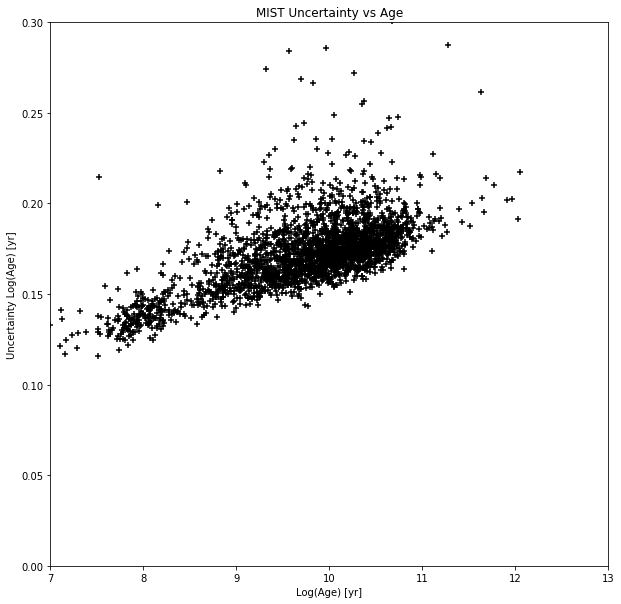

In [13]:
########################
### Uncertainty Plot ###
########################

plt.figure(figsize=[10,10])
plt.scatter(misage,devs,c='k',marker='+',label='Polynomial')
#plt.scatter(clnpdfout['P_MEAN'],clnpdfout['P_VAR'],c='r',marker='+',label='Bayesian')
plt.xlim(7,13)
#plt.axvline(10.13+np.mean(devs),c='k')
plt.xlabel(r'Log(Age) [yr]')
plt.ylabel(r'Uncertainty Log(Age) [yr]')
plt.ylim(0.0,0.3)
plt.title(r'MIST Uncertainty vs Age')
#plt.legend()
plt.savefig('mist_uncert_age.pdf',bbox_inches='tight')
plt.show()

In [14]:
#############################
### Match old DR16 to R13 ###
#############################

'''Diane used the old file'''

xy, x_ind, y_ind = np.intersect1d(clnrolddr16['APOGEE_ID'], clndr16['APOGEE_ID'],return_indices=True)

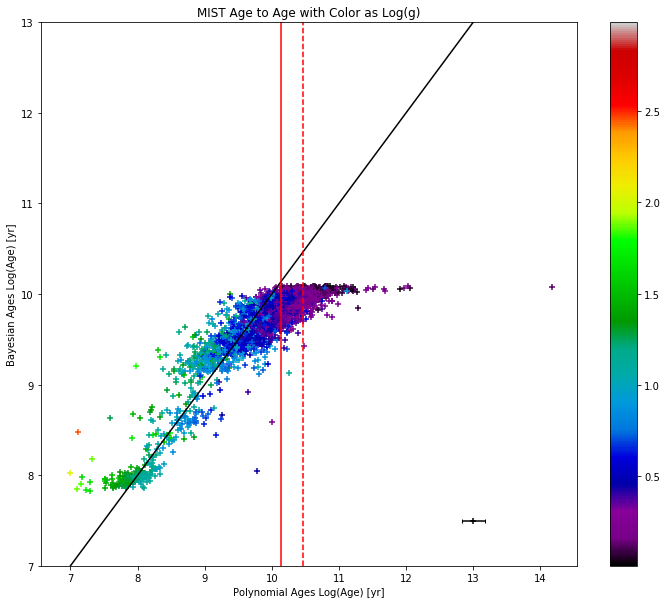

In [15]:
########################
### compare to Diane ###
########################

plt.figure(figsize=[12,10])
plt.scatter(misage[y_ind],clnpdfout['P_MEAN'][x_ind],c=clndr16['LOGG'][y_ind],marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.plot([7,8,9,10,11,12,13],[7,8,9,10,11,12,13],c='k')
plt.ylim(7,13)
plt.scatter(13,7.5,c='k',marker='+')
plt.errorbar(13,7.5,xerr=np.mean(devs),c='k',capsize=2)
plt.axvline(10.13,c='r')
plt.axvline(10.13+np.max(devs),c='r',linestyle='--')
plt.xlabel(r'Polynomial Ages Log(Age) [yr]')
plt.ylabel(r'Bayesian Ages Log(Age) [yr]')
plt.title(r'MIST Age to Age with Color as Log(g)')
plt.savefig('mist_age_age.pdf',bbox_inches='tight')
plt.show()

In [18]:
print(len(np.where(misage[x_ind]>(10.13+np.max(np.asarray(devs)[x_ind]))))/len(misage[x_ind])*100)
print(len(np.where(misage>(10.13+np.max(devs))))/len(misage)*100)
print(len(np.where(misage[x_ind]>(10.13+np.mean(np.asarray(devs)[x_ind]))))/len(misage[x_ind])*100)
print(len(np.where(misage>(10.13+np.mean(devs))))/len(misage)*100)

0.044111160123511246
0.04120313143798929
0.044111160123511246
0.04120313143798929


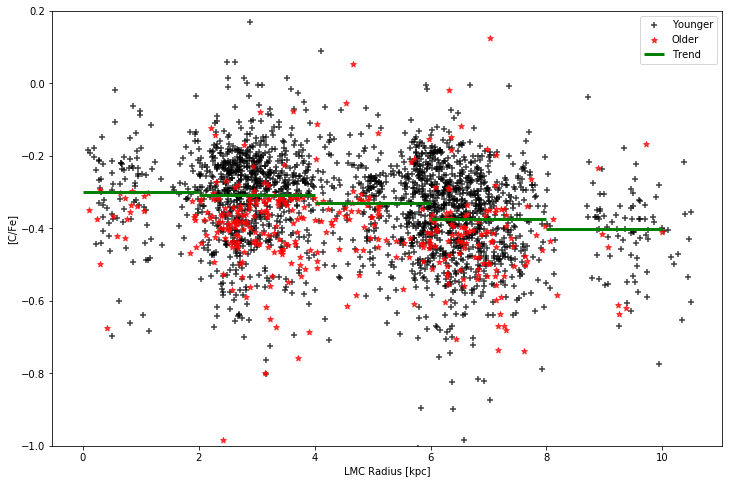

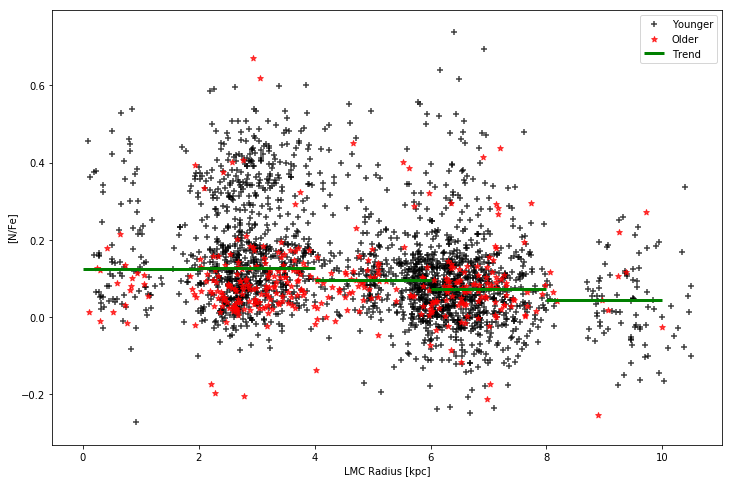

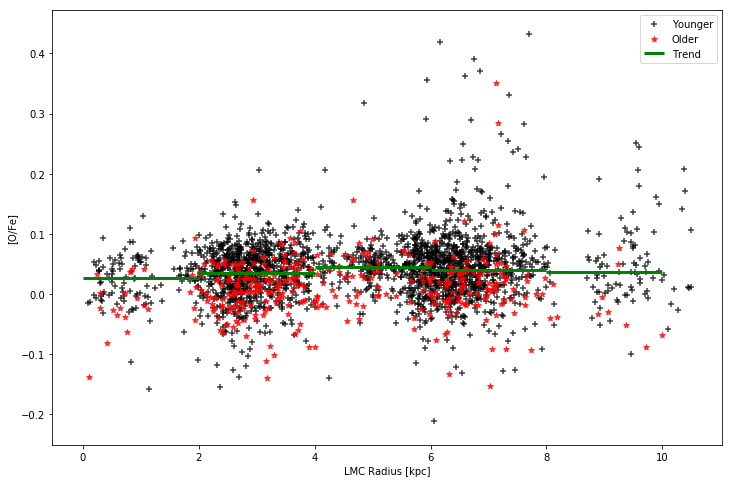

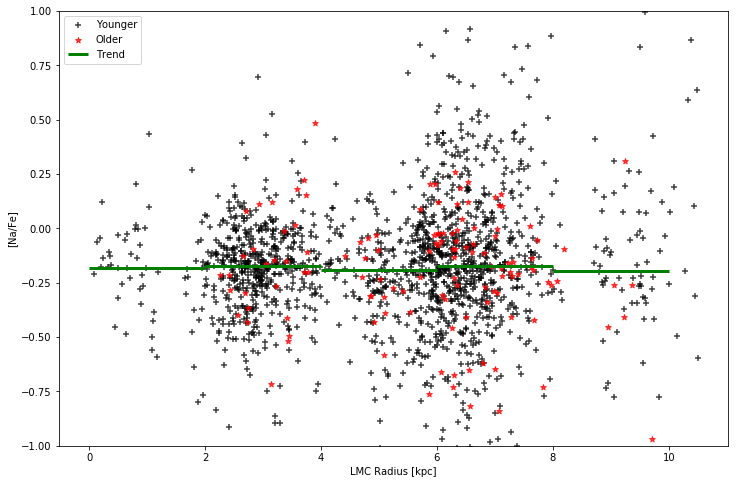

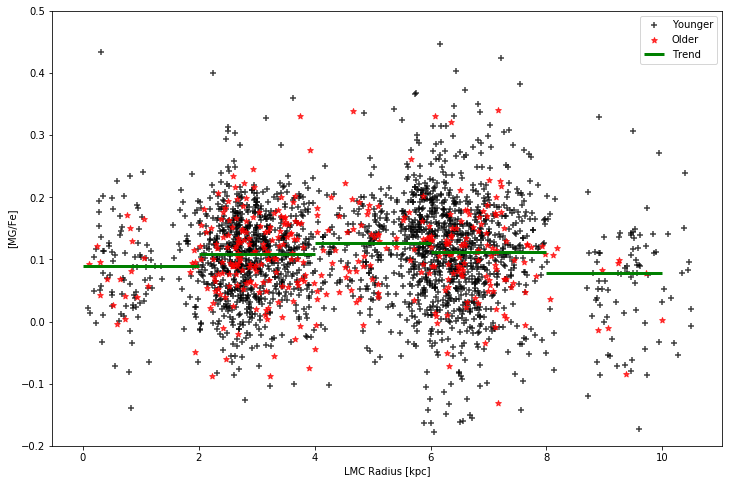

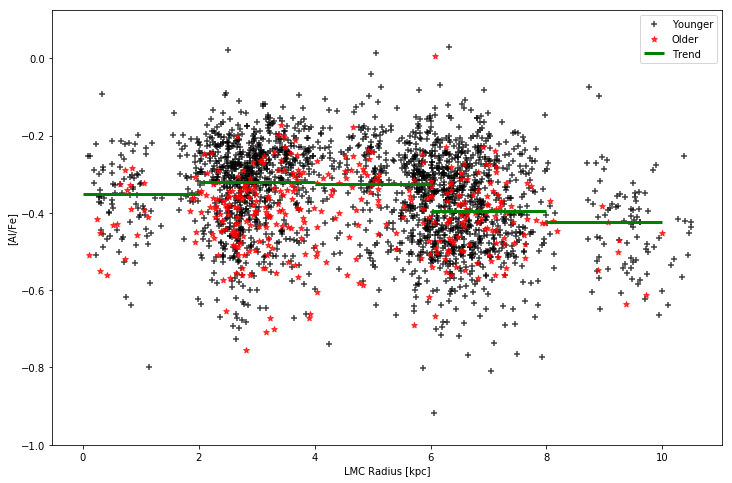

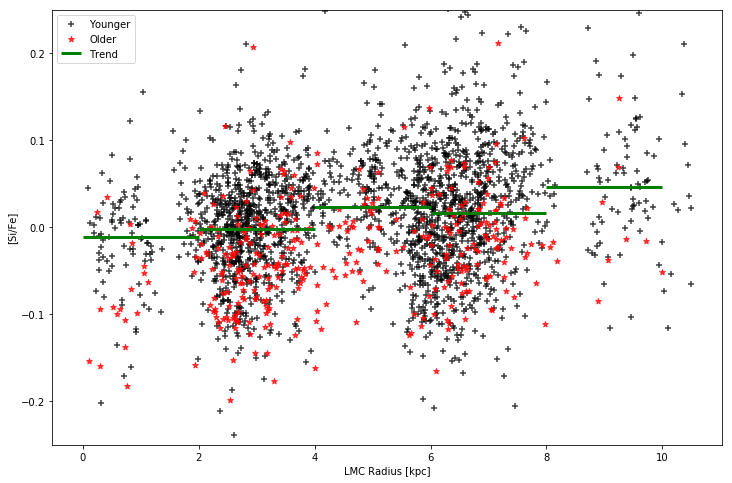

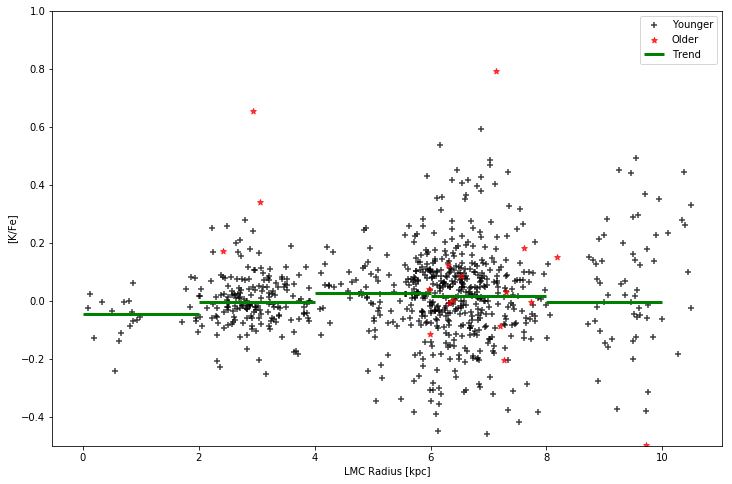

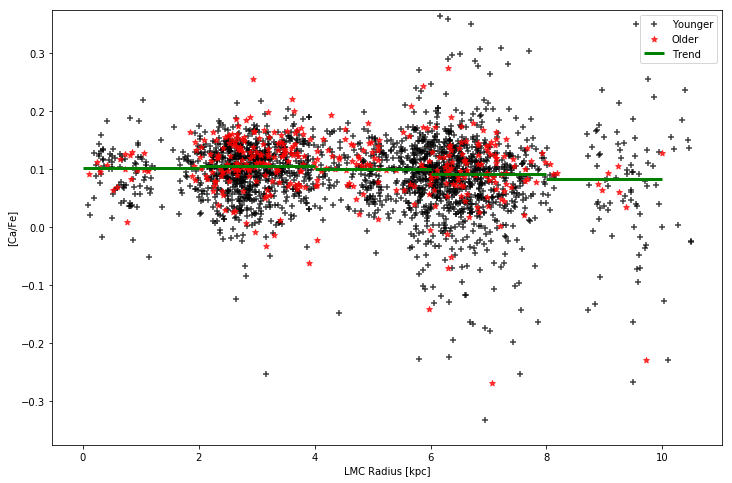

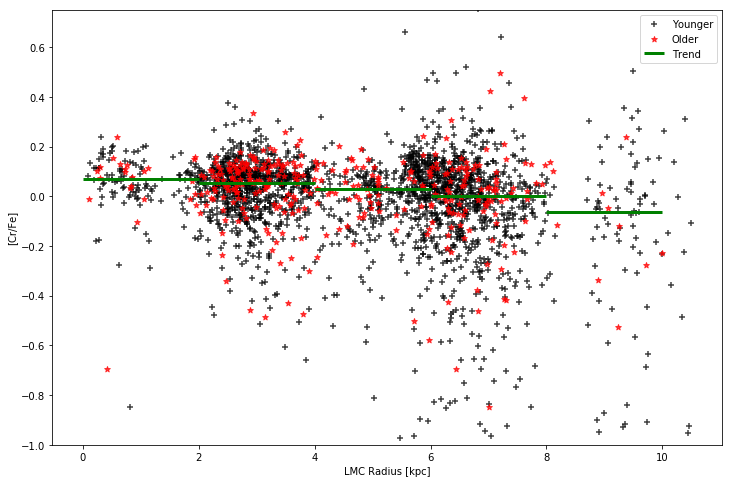

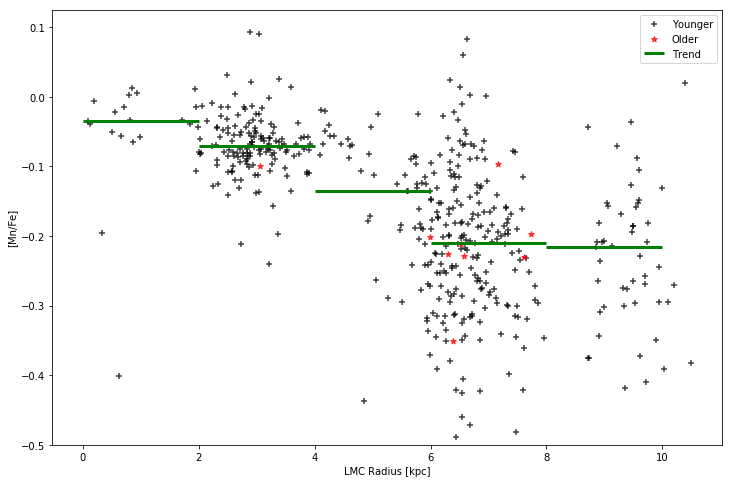

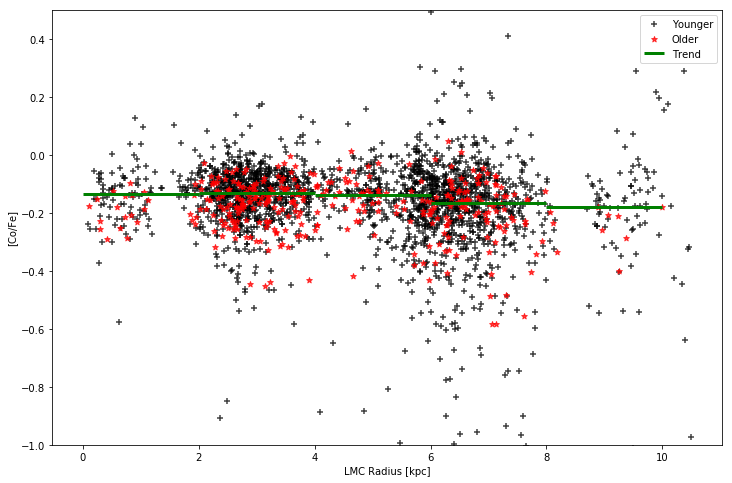

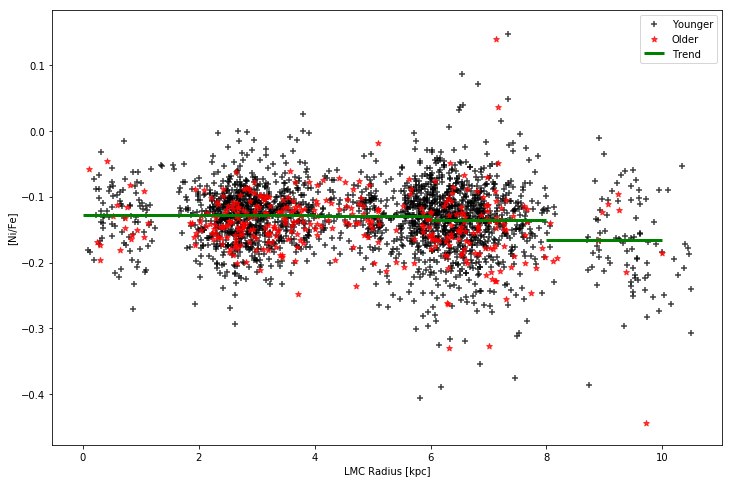

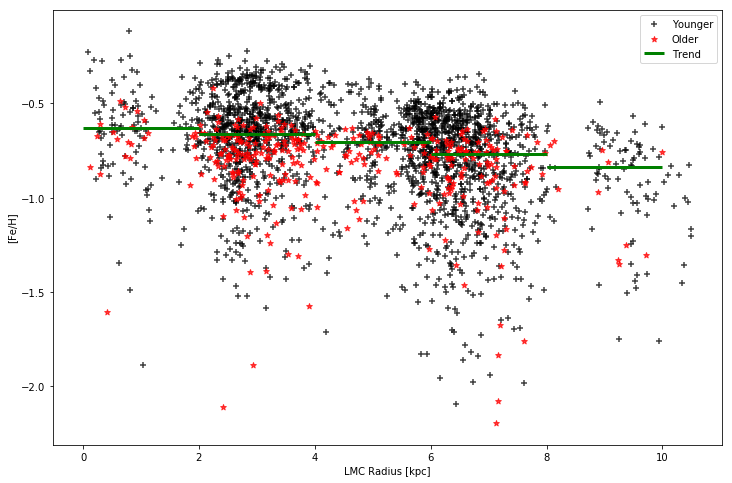

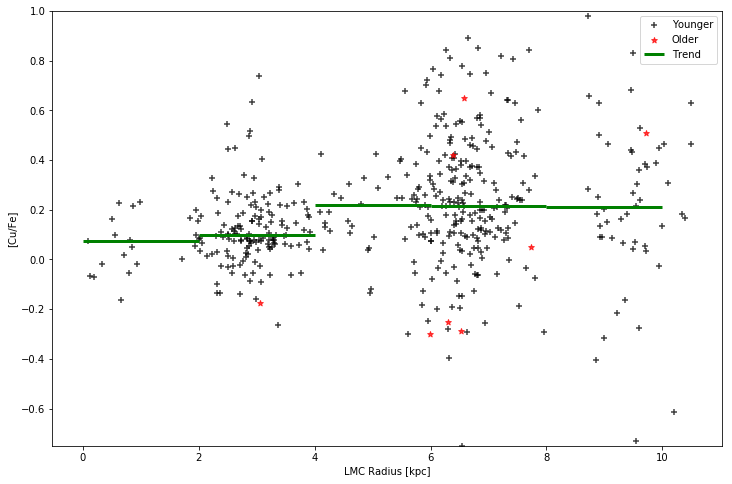

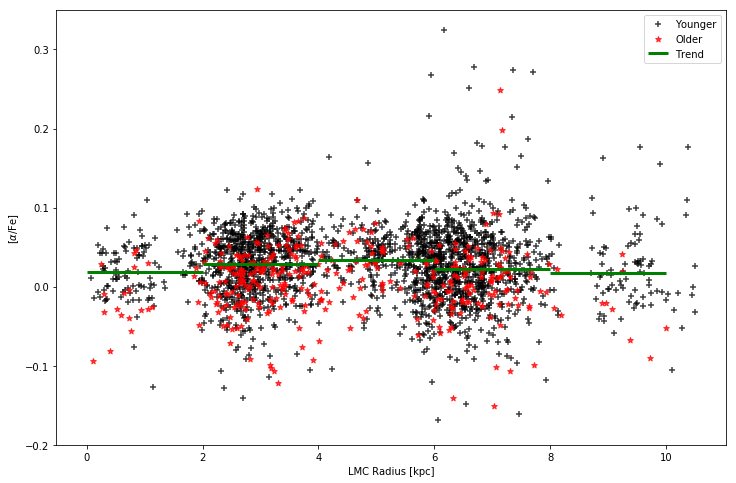

In [19]:
#####################################################
### Age-Abundance-Radius Relations For Two Groups ###
#####################################################

senex = np.where(misage > (10.13+np.max(devs)))
iuvenis = np.where(misage < (10.13+np.max(devs))) 

# senex = np.where(parage > 10.13)
# iuvenis = np.where(parage < 10.13)

import scipy.stats as st

### Carbon
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['C_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['C_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'],clndr16['C_FE'],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[C/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-1,0.2)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewmist_c.jpg',bbox_inches='tight')
plt.show()

### Nitrogen
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['N_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['N_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'],clndr16['N_FE'],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[N/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
#plt.ylim(-1,0.2)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewmist_n.jpg',bbox_inches='tight')
plt.show()

### Oxygen
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['O_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['O_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'],clndr16['O_FE'],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[O/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
#plt.ylim(-1,0.2)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewmist_o.jpg',bbox_inches='tight')
plt.show()

### Sodium
clnna = np.where(clndr16['NA_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['NA_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['NA_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnna],clndr16['NA_FE'][clnna],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[Na/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-1,1)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewmist_na.jpg',bbox_inches='tight')
plt.show()

### Magnesium
clnmg = np.where(clndr16['MG_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['MG_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['MG_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnmg],clndr16['MG_FE'][clnmg],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[MG/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-0.2,0.5)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewmist_mg.jpg',bbox_inches='tight')
plt.show()

### Aluminium
clnal = np.where(clndr16['AL_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['AL_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['AL_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnal],clndr16['AL_FE'][clnal],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[Al/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-1,0.125)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewmist_al.jpg',bbox_inches='tight')
plt.show()

### Silicon
clnsi = np.where(clndr16['SI_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['SI_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['SI_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnsi],clndr16['SI_FE'][clnsi],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[Si/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-0.25,0.25)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewmist_si.jpg',bbox_inches='tight')
plt.show()

### Potassium
clnk = np.where(clndr16['K_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['K_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['K_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnk],clndr16['K_FE'][clnk],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[K/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-0.5,1.0)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewmist_k.jpg',bbox_inches='tight')
plt.show()

### Calcium
clnca = np.where(clndr16['CA_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['CA_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['CA_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnca],clndr16['CA_FE'][clnca],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[Ca/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-0.375,0.375)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewmist_ca.jpg',bbox_inches='tight')
plt.show()

### Chromium
clncr = np.where(clndr16['CR_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['CR_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['CR_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clncr],clndr16['CR_FE'][clncr],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[Cr/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-1.0,0.75)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewmist_cr.jpg',bbox_inches='tight')
plt.show()

### Maganese
clncr = np.where(clndr16['MN_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['MN_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['MN_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clncr],clndr16['MN_FE'][clncr],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[Mn/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-0.5,0.125)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewmist_mn.jpg',bbox_inches='tight')
plt.show()

### Cobalt
clnco = np.where(clndr16['CO_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['CO_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['CO_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnco],clndr16['CO_FE'][clnco],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[Co/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-1,0.5)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewmist_co.jpg',bbox_inches='tight')
plt.show()

### Nickel
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['NI_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['NI_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'],clndr16['NI_FE'],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[Ni/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
#plt.ylim(-1,0.2)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewmist_ni.jpg',bbox_inches='tight')
plt.show()

### Iron
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['FE_H'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['FE_H'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'],clndr16['FE_H'],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[Fe/H]')
plt.xlabel(r'LMC Radius [kpc]')
# plt.ylim(-1,0.2)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewmist_fe.jpg',bbox_inches='tight')
plt.show()

### Copper
clncu = np.where(clndr16['CU_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['CU_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['CU_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clncu],clndr16['CU_FE'][clncu],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[Cu/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-0.75,1.0)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewmist_cu.jpg',bbox_inches='tight')
plt.show()

### Alpha
#clncu = np.where(clndr16['CU_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],(clndr16['ALPHA_M']+clndr16['M_H']-clndr16['FE_H'])[iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],(clndr16['ALPHA_M']+clndr16['M_H']-clndr16['FE_H'])[senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'],(clndr16['ALPHA_M']+clndr16['M_H']-clndr16['FE_H']),statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[$\alpha$/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-0.2,0.35)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewmist_alpha.jpg',bbox_inches='tight')
plt.show()


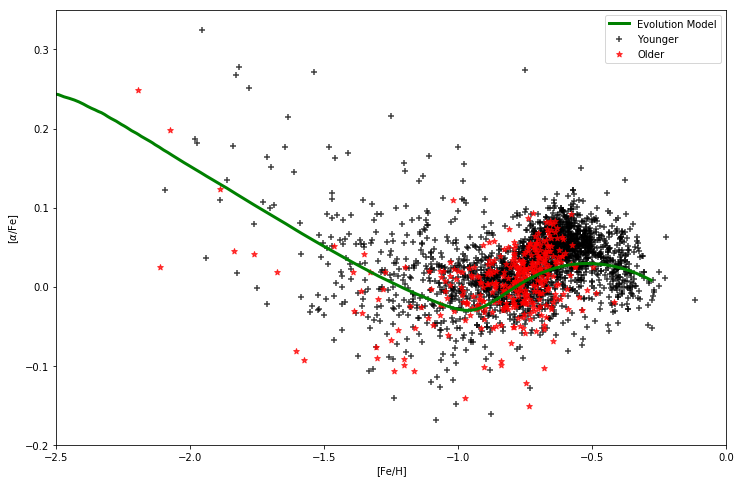

In [20]:
### Alpha to Iron plot
alphachris = np.mean([Chrismod['OFe'],Chrismod['MgFe'],Chrismod['SiFe'],Chrismod['CaFe']],axis=0)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['FE_H'][iuvenis],(clndr16['ALPHA_M']+clndr16['M_H']-clndr16['FE_H'])[iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['FE_H'][senex],(clndr16['ALPHA_M']+clndr16['M_H']-clndr16['FE_H'])[senex],marker='*',c='r',alpha=0.75,label='Older')
plt.plot(Chrismod['FeH'],alphachris,c='g',label='Evolution Model',lw=3)
#bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'],(clndr16['ALPHA_M']+clndr16['M_H']-clndr16['FE_H']),statistic='median', bins=[0,2,4,6,8,10])
#plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[$\alpha$/Fe]')
plt.xlabel(r'[Fe/H]')
plt.ylim(-0.2,0.35)
plt.xlim(-2.5,0.0)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewmist_alphafe.jpg',bbox_inches='tight')
plt.show()

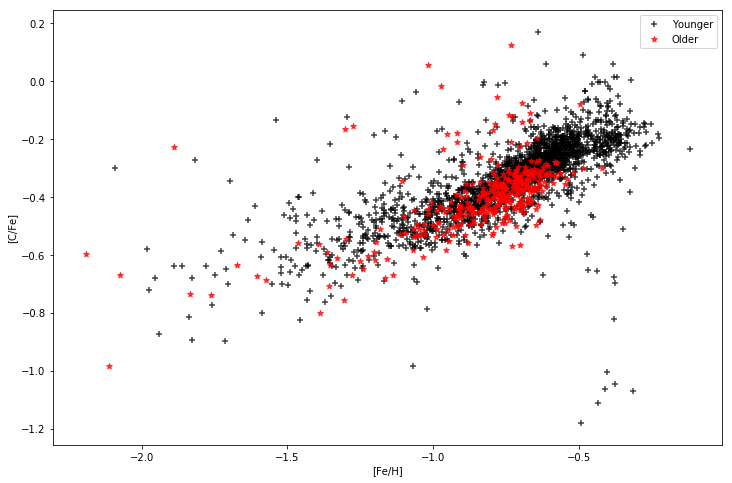

In [21]:
### Alpha to Iron plot
# alphachris = np.mean([Chrismod['OFe'],Chrismod['MgFe'],Chrismod['SiFe'],Chrismod['CaFe']],axis=0)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['FE_H'][iuvenis],clndr16['C_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['FE_H'][senex],clndr16['C_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
# plt.plot(Chrismod['FeH'],alphachris,c='g',label='Evolution Model',lw=3)
#bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'],(clndr16['ALPHA_M']+clndr16['M_H']-clndr16['FE_H']),statistic='median', bins=[0,2,4,6,8,10])
#plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[C/Fe]')
plt.xlabel(r'[Fe/H]')
# plt.ylim(-0.2,0.35)
# plt.xlim(-2.5,0.0)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
# plt.savefig('oldnewparsec_alphafe.jpg',bbox_inches='tight')
plt.show()

In [34]:
print(len(np.squeeze(senex))/len(misage)==len(np.squeeze(np.where(misage>(10.13+np.max(devs)))))/len(misage))

print(len(np.squeeze(np.where(misage>(10.13+np.max(devs)))))/len(misage))
print(len(np.squeeze(senex))/len(misage))

True
0.1508034610630408
0.1508034610630408


In [36]:
print(len(np.where(misage[x_ind]>(10.13+np.max(np.asarray(devs)[x_ind]))))/len(misage[x_ind])*100)

0.044111160123511246
0.00041203131437989287


In [39]:
len(np.squeeze(np.where(misage[x_ind]>(10.13+np.max(np.asarray(devs)[x_ind])))))/len(misage[x_ind])

0.1517423908248787